## Autoencoder

An autoencoder is an unsupervised learning technique for neural networks that learns efficient data representations (encoding) by training the network to ignore signal “noise.” Autoencoders can be used for image denoising, image compression, and, in some cases, even generation of image data.

## Flow of Autoencoder

Noisy Image -> Encoder -> Compressed Representation -> Decoder -> Reconstruct Clear Image

## Import Modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, Add, Input
from keras.datasets import mnist

# Enable GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load the Dataset

In [3]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split

# Path to the parent directory where numbered folders exist
base_dir = "/Users/yfahmy/Downloads/mini-english-01-package"
image_dim = 200 # 128 works, lets try 256

# Initialize lists for images and labels
images = []

for folder_num in range(1, 10000): 
    folder_path = os.path.join(base_dir, str(folder_num))
    image_path = os.path.join(folder_path, "01.jpg")

    # Check if the image exists
    if os.path.exists(image_path):
        try:
            img = Image.open(image_path).convert("RGB") 
            img = img.resize((image_dim, image_dim)) 

            images.append(np.array(img)) 
        except Exception as e:
            print(f"Error loading {image_path}: {e}")

images = np.array(images)

x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape(len(x_train), image_dim, image_dim, 3)
x_test = x_test.reshape(len(x_test), image_dim, image_dim, 3)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (7736, 200, 200, 3), x_test shape: (1935, 200, 200, 3)


## Add Gaussian Noise

In [4]:
noise_factor = 0.075
# Gaussian Noise
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

## Add Salt and Pepper Noise

In [5]:
def add_s_and_p_noise_batch(images, salt_prob=0.01, pepper_prob=0.01):
    N, H, W, C = images.shape
    rand_matrix = np.random.rand(N, H, W)
    salt_mask = rand_matrix < salt_prob
    pepper_mask = rand_matrix > (1 - pepper_prob)
    images[salt_mask] = 255
    images[pepper_mask] = 0
    return images

x_train_noisy = add_s_and_p_noise_batch(x_train_noisy)
x_test_noisy = add_s_and_p_noise_batch(x_test_noisy)

In [6]:
# clip the values in the range of 0-1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Exploratory Data Analysis

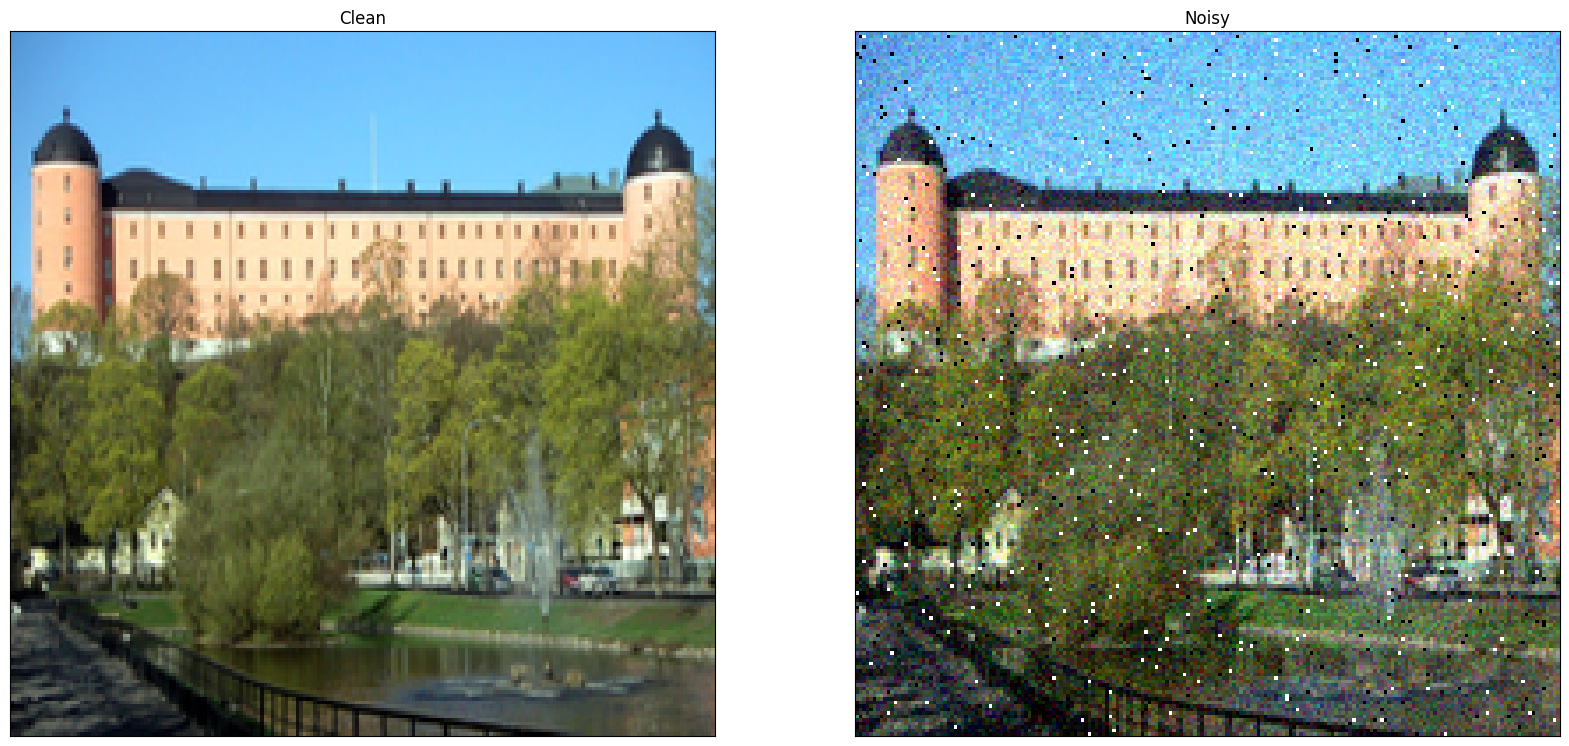

In [7]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(20, 10))
# display original image
ax = plt.subplot(1, 2, 1)
plt.imshow(x_test[index].reshape(image_dim,image_dim,3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Clean")
# display noisy image
ax = plt.subplot(1, 2, 2)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Noisy")
plt.show()

## Model Creation

In [8]:
input_img = Input(shape=(image_dim, image_dim, 3))  # RGB images

# First layer (Conv + ReLU)
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

for _ in range(6): 
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

# Last layer (Conv, No Activation)
x = Conv2D(3, (3, 3), padding='same')(x)

# Skip Connection (Residual Learning)
output_img = Add()([input_img, x])

model = Model(inputs=input_img, outputs=output_img)

model.compile(optimizer='adam', loss='mse')
model.summary()

2025-03-16 13:51:20.565768: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-03-16 13:51:20.565934: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-03-16 13:51:20.565947: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-03-16 13:51:20.566095: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-16 13:51:20.566107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 200,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 200, 200,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200, 200,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 200, 200,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 200, 200,  │     36,928 │ re_lu_4[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 200,  │        256 │ conv2d_5[0][0]  

 Total params: 226,627 (885.26 KB)

 Trainable params: 225,859 (882.26 KB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
# train the model
model.fit(x_train_noisy, x_train, epochs=200 , batch_size=64, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/200


2025-03-16 13:51:41.264042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-16 13:51:41.278302: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
/opt/homebrew/anaconda3/envs/torch/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 538ms/step - val_loss: 0.0129
Epoch 2/200


## Visualize the Results

In [ ]:
# predict the results from model (get compressed images)
pred = model.predict(x_test_noisy)

2025-03-16 06:15:17.537648: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015610972..1.0371504].


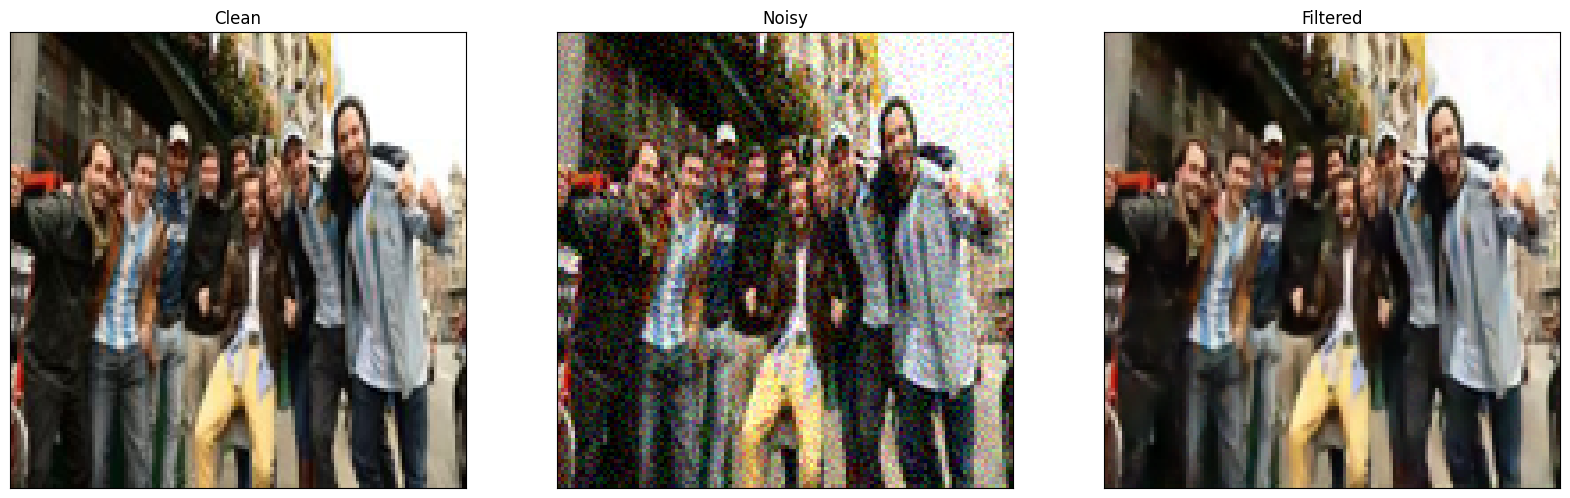

In [181]:
index = np.random.randint(len(x_test))
plt.figure(figsize=(20, 10))
# display original image
ax = plt.subplot(1, 3, 1)
plt.imshow(x_test[index].reshape(image_dim,image_dim,3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Clean")
# display noisy image
ax = plt.subplot(1, 3, 2)
plt.imshow(x_test_noisy[index].reshape(image_dim,image_dim,3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Noisy")
# display cleaned image
ax = plt.subplot(1, 3, 3)
plt.imshow(pred[index].reshape(image_dim,image_dim,3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Filtered")
plt.show()